#Image Captioning: LSTM Decoder
Simran Nayyar, Dina Dehaini, David Wang, Aditi Krishnakumar

LIGN 167

### References:
* https://www.tensorflow.org/tutorials/text/image_captioning
* https://cs.stanford.edu/people/karpathy/cvpr2015.pdf
* https://www.analyticsvidhya.com/blog/2018/04solving-an-image-captioning-task-using-deep-learning/
* Dataset: http://cocodataset.org/#home

In [ ]:
# import relevant packages
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from tqdm import tqdm
import pickle

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

## Downloading the dataset
Each image has around 5 captions each

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

 1901993984/13510573713 [===>..........................] - ETA: 15:12

## Limit the size of the training set 
Using a subset of 10,000 images (50,000 captions approximately)

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:10000]
print(len(train_image_paths))

10000


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A man sitting in a bathroom sink under a mirror. <end>


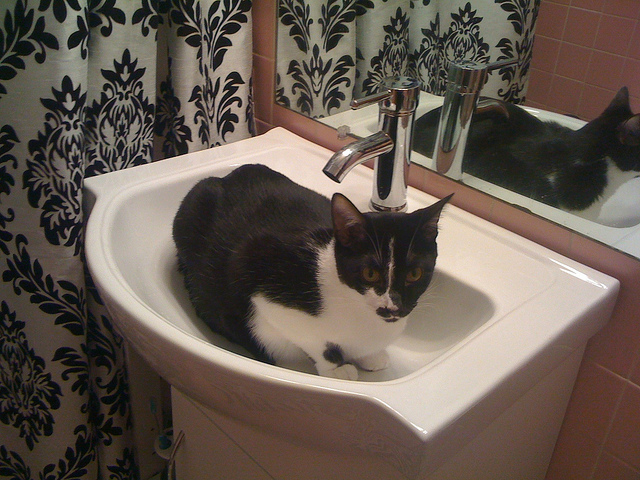

In [ ]:
# Example
print(train_captions[0])
Image.open(img_name_vector[0])

## Pretrained model: InceptionV3
Resizing and Normalizing the images

In [ ]:
# resizing image to 299x299pixels
# normalize pixels ([-1,-1])
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Load pre-trained ImageNet weights
The output layer of image_features_extract_model is the last convolutional layer in Pre-trained model. 


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


## Caching the features extracted from InceptionV3
Cache output to disk after processing images through pre-trained model. 

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

Transform the text captions into integer sequences using the TextVectorization layer, with the following steps:

* Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words.
* Tokenize all captions by mapping each word to it's index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split the data into Training and Testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt]) # number of ref captions per image
  img_name_train.extend([imgt] * capt_len) # image files * number of ref captions
  cap_train.extend(img_to_cap_vector[imgt]) # captions as vector

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv]) # number of ref captions per image
  img_name_val.extend([imgv] * capv_len) # image files * number of ref captions
  cap_val.extend(img_to_cap_vector[imgv]) # captions as vector

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(40019, 40019, 10008, 10008)

In [ ]:
# save larger variables so easy to reload next time
with open("img_name_train", "wb") as fp:   #Pickling
  pickle.dump(img_name_train, fp)
with open("img_name_val", "wb") as fp:   #Pickling
  pickle.dump(img_name_val, fp)
with open("cap_train", "wb") as fp:   #Pickling
  pickle.dump(cap_train, fp)
with open("cap_val", "wb") as fp:   #Pickling
  pickle.dump(cap_val, fp)

## Create a tf.data dataset for training and testing


In [ ]:
# Uncomment if want to re-load variables

# with open("img_name_train", "rb") as fp:   # Unpickling
#   img_name_train = pickle.load(fp)
# with open("img_name_val", "rb") as fp:   # Unpickling
#   img_name_val = pickle.load(fp)
# with open("cap_train", "rb") as fp:   # Unpickling
#   cap_train = pickle.load(fp)
# with open("cap_val", "rb") as fp:   # Unpickling
#   cap_val = pickle.load(fp)
# #with open("img_to_cap_vector", "rb") as fp:   # Unpickling
#   #img_to_cap_vector = pickle.load(fp)

In [ ]:
# Parameters 
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
valdataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
 
# Use map to load the numpy files in parallel
valdataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)
 
# Shuffle and batch
valdataset = valdataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valdataset = valdataset.prefetch(buffer_size=tf.data.AUTOTUNE)


## Model
* Extract the features from the lower convolutional layer of InceptionV3.
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here LSTM) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
  
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    self.lstm = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    #whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
    output, hidden, state = self.lstm(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, hidden, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

## Optimizer and Loss Function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint
Save model at checkpoints

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training


In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image

  hidden = decoder.reset_state(batch_size=target.shape[0])

  # start token
  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
@tf.function
def evaluate_step(img_tensor_val, target):
    loss = 0
 
    hidden = decoder.reset_state(batch_size=target.shape[0])
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)
 
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        loss += loss_function(target[:, i], predictions)
       
    total_loss = (loss / int(target.shape[1]))
    return loss, total_loss


In [ ]:
EPOCHS = 20
val_losses = []
loss_plot = []
start = 0
end = 50
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    vtotal_loss = 0
 
    for (batch, (img_tensor, target)) in enumerate(valdataset[start:end]):  #valdataset[start:end] //increase start and end by 1/n each epoch
            vbatch_loss, vt_loss = evaluate_step(img_tensor, target)
            vtotal_loss += vt_loss
 
            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
 
    val_losses.append(vtotal_loss / num_steps)
 
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
 
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
 
    
  start += 50
  end += 50
 
    if epoch % 5 == 0:
      ckpt_manager.save()
 
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')


In [ ]:
encoder.save('saved_model_LSTM/encoder')
decoder.save('saved_model_LSTM/decoder')

## Loss Plot

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Testing

* The evaluate function does not use the teacher forcing method. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* Store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # comment below if reloading model
    hidden = decoder.reset_state(batch_size=1)

    #hidden = tf.zeros((1, units))

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        # stop predicting if reach end token
        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Testing

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
# convert vector to sentence
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])

# prediction
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))

# attention plot
plot_attention(image, result, attention_plot)
Image.open(image)

## BLEU Score

In [ ]:
# smoothening function
smoothie = SmoothingFunction().method4

In [ ]:
import nltk
nltk.download('omw-1.4')

In [ ]:
# checking BLEU function
ref  = ["this is an image of three sheep in a field".split(' ')]
pred = "two sheep and a baby sheep standing on lush green field".split(' ')
score1 = sentence_bleu(ref, pred, weights=(1, 0, 0, 0))
score4 = sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25)) # default

print(score1,score4)

## Evaluating on Validation set

Attempt to improve BLEU by having multiple captions as references per image. GPU constraints did not allow this

In [ ]:
# attempt to have multiple captions as references per image
img_to_captions = {}
i = 0
for img in img_name_val:
  cvecs = img_to_cap_vector[img]
  captions = []
  for cvector in cvecs:
    sentence = []
    for word in cvector:
      if word not in [0,3,4]: # remove '','<start>','<end>'
        sentence.append(tf.compat.as_text(index_to_word(word).numpy()))
    captions.append(sentence)
  img_to_captions[img] = captions
  i+=1
  print(i,end=" ")

In [ ]:
# NEW BLEU: GPU constraints did not allow this
i = 0
bleu_4_new = []
bleu_1_new = []
while i < len(img_name_val):
  image = img_name_val[i][9:] # get rid of "/content/"
  cap_len = len(img_to_cap_vector[img_name_val[i]])
  ref = img_to_captions[image]
  for caption in ref:
    if '<start>' in caption:
      caption.remove('<start>')
    if '<end>' in caption:
      caption.remove('<end>')
  pred, attention_plot = evaluate(img_name_val[i])
  if '<start>' in pred:
    pred.remove('<start>')
  if '<end>' in pred:
    pred.remove('<end>')
  score1 = sentence_bleu(ref, pred, weights=(1, 0, 0, 0))
  score4 = sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25))
  bleu_1_new.append(score1)
  bleu_4_new.append(score4)
  print(i)
  i += cap_len

Calculate BLEU scores with single caption as reference per image

In [ ]:
# OLD BLEU WITH 1 REF
i = 0
bleu_1 = [] # weights = 1,0,0,0
bleu_4 = [] # weights = 0.25, 0.25, 0.25, 0.25

# iterate through validation set
while i < len(img_name_val):
  image = img_name_val[i]
  cap_len = len(img_to_cap_vector[img_name_val[i]])

  # convert reference vector to sentence
  ref = [tf.compat.as_text(index_to_word(word).numpy())
                         for word in cap_val[i] if word not in [0]]
  # remove start and end tokens before calculating BLEU scores                
  if '<start>' in ref:
    ref.remove('<start>')
  if '<end>' in ref:
    ref.remove('<end>')
  ref = [ref]

  # predicted sentence
  pred, attention_plot = evaluate(image)
  if '<start>' in pred:
    pred.remove('<start>')
  if '<end>' in pred:
    pred.remove('<end>')
  
  score1 = sentence_bleu(ref, pred, weights=(1, 0, 0, 0))
  score4 = sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25))
  bleu_1.append(score1)
  bleu_4.append(score4)
  print(i)
  i += cap_len

In [ ]:
# save BLEU scores
with open("bleu_1", "wb") as fp:   #Pickling
  pickle.dump(bleu_1, fp)
with open("bleu_4", "wb") as fp:   #Pickling
  pickle.dump(bleu_4, fp)

In [ ]:
# calculate average scores
avg_bleu_1 = sum(bleu_1)/len(bleu_1)
avg_bleu_4 = sum(bleu_4)/len(bleu_4)

Average BLEU Score

In [ ]:
print("Average BLEU Score", avg_bleu)
print("Average BLEU_1 Score", avg_bleu_1)

In [ ]:
plt.plot(bleu_1)

In [ ]:
plt.plot(bleu_4)
plt.title("BLEU Score per Image")
plt.ylabel("BLEU Score")
plt.show()